## Mount drive & imports


In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/MIR

import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/MIR'
/content/drive/My Drive/MIR


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load pre-computed feature sets 

In [19]:
#E_train_data_file = 'MER_audio_taffc_dataset/train_segments/train_data.csv'
#C_train_data_file = 'CH-818/train_segments/train_data.csv'
#T_train_data_file = 'tr-music-dataset/train_segments/train_data.csv'

#E_test_data_file = 'MER_audio_taffc_dataset/test_segments/test_data.csv'
#C_test_data_file = 'CH-818/test_segments/test_data.csv'
#T_test_data_file = 'tr-music-dataset/test_segments/test_data.csv'

E_train_data_file = 'smile-features/4Q-train-features.csv'
C_train_data_file = 'smile-features/CH-train-features.csv' 
T_train_data_file = 'smile-features/TR-train-features.csv'

E_test_data_file = 'smile-features/4Q-test-features.csv' 
C_test_data_file = 'smile-features/CH-test-features.csv'
T_test_data_file = 'smile-features/TR-test-features.csv' 

E_train_data = pd.read_csv(E_train_data_file)
C_train_data = pd.read_csv(C_train_data_file)
T_train_data = pd.read_csv(T_train_data_file)

E_test_data = pd.read_csv(E_test_data_file)
C_test_data = pd.read_csv(C_test_data_file)
T_test_data = pd.read_csv(T_test_data_file)

Normalize features

In [20]:
min_max_scaler = preprocessing.MinMaxScaler()

E_train_data_modif = E_train_data.copy()
C_train_data_modif = C_train_data.copy()
T_train_data_modif = T_train_data.copy()

E_test_data_modif = E_test_data.copy()
C_test_data_modif = C_test_data.copy()
T_test_data_modif = T_test_data.copy()

n = 84 # Change number of features: 84 for Essentia, 260 for IS13ComParE
E_train_data_modif.iloc[:,:n] = min_max_scaler.fit_transform(E_train_data.iloc[:,:n].values)
C_train_data_modif.iloc[:,:n] = min_max_scaler.fit_transform(C_train_data.iloc[:,:n].values)
T_train_data_modif.iloc[:,:n] = min_max_scaler.fit_transform(T_train_data.iloc[:,:n].values)

E_test_data_modif.iloc[:,:n] = min_max_scaler.fit_transform(E_test_data.iloc[:,:n].values)
C_test_data_modif.iloc[:,:n] = min_max_scaler.fit_transform(C_test_data.iloc[:,:n].values)
T_test_data_modif.iloc[:,:n] = min_max_scaler.fit_transform(T_test_data.iloc[:,:n].values)

Balance training datasets

In [21]:
# Balancing data
def balance(data_modif, q):
    min_number = data_modif.emotion.value_counts()[q]
    q1_data = data_modif[data_modif.emotion == 'q1'].sample(n = min_number, random_state = 42)
    q2_data = data_modif[data_modif.emotion == 'q2'].sample(n = min_number, random_state = 42)
    q3_data = data_modif[data_modif.emotion == 'q3'].sample(n = min_number, random_state = 42)
    q4_data = data_modif[data_modif.emotion == 'q4'].sample(n = min_number, random_state = 42)
    return pd.concat([q1_data, q2_data, q3_data, q4_data])

E_train_data_modif = balance(E_train_data_modif, 'q2') #q2 had the fewest samples
C_train_data_modif = balance(C_train_data_modif, 'q3') #q3 had the fewest samples
T_train_data_modif = balance(T_train_data_modif, 'q2') #q2 had the fewest samples

print(E_train_data_modif.emotion.value_counts())
print(C_train_data_modif.emotion.value_counts())
print(T_train_data_modif.emotion.value_counts())

q3    708
q4    708
q1    708
q2    708
Name: emotion, dtype: int64
q1    264
q3    264
q2    264
q4    264
Name: emotion, dtype: int64
q1    296
q3    296
q2    296
q4    296
Name: emotion, dtype: int64


Prepare data arrays with features and labels

In [22]:
#Input values put in a matrix, there are 84 / 260 features
E_train_X = E_train_data_modif.iloc[:,:n].values 
C_train_X = C_train_data_modif.iloc[:,:n].values 
T_train_X = T_train_data_modif.iloc[:,:n].values 

E_test_X = E_test_data_modif.iloc[:,:n].values 
C_test_X = C_test_data_modif.iloc[:,:n].values 
T_test_X = T_test_data_modif.iloc[:,:n].values 

#Output values
E_train_data_modif.emotion = pd.Categorical(E_train_data_modif.emotion) #convert to categorical data
C_train_data_modif.emotion = pd.Categorical(C_train_data_modif.emotion)
T_train_data_modif.emotion = pd.Categorical(T_train_data_modif.emotion)

E_test_data_modif.emotion = pd.Categorical(E_test_data_modif.emotion) 
C_test_data_modif.emotion = pd.Categorical(C_test_data_modif.emotion)
T_test_data_modif.emotion = pd.Categorical(T_test_data_modif.emotion) 

E_train_y = np.array(E_train_data_modif.emotion.cat.codes) #create label encoded outputs
C_train_y = np.array(C_train_data_modif.emotion.cat.codes) 
T_train_y = np.array(T_train_data_modif.emotion.cat.codes) 

E_test_y = np.array(E_test_data_modif.emotion.cat.codes)
C_test_y = np.array(C_test_data_modif.emotion.cat.codes) 
T_test_y = np.array(T_test_data_modif.emotion.cat.codes) 

print('E_X_train shape is ', E_train_X.shape)
print('E_X_test shape is ', E_test_X.shape, '\n')
print('C_X_train shape is ', C_train_X.shape)
print('C_X_test shape is ', C_test_X.shape, '\n')
print('T_X_train shape is ', T_train_X.shape)
print('T_X_test shape is ', T_test_X.shape)

E_X_train shape is  (2832, 84)
E_X_test shape is  (720, 84) 

C_X_train shape is  (1056, 84)
C_X_test shape is  (288, 84) 

T_X_train shape is  (1184, 84)
T_X_test shape is  (320, 84)


Prepare data arrays for mixed training

In [23]:
X_train = []
y_train = []

def append(c, i, X, y):
    c += 1
    X_train.append(X[i])
    y_train.append(y[i])
    return c

def add_for_set(X, y):
    c1 = 0; c2 = 0; c3 = 0; c4 = 0
    for i, emotion in enumerate(y): 
        if emotion == 0 and c1 < 264:
            c1 = append(c1, i, X, y)
        elif emotion == 1 and c2 < 264:
            c2 = append(c2, i, X, y)
        elif emotion == 2 and c3 < 264:
            c3 = append(c3, i, X, y)
        elif emotion == 3 and c4 < 264:
            c4 = append(c4, i, X, y)

add_for_set(E_train_X, E_train_y)
add_for_set(C_train_X, C_train_y)
add_for_set(T_train_X, T_train_y)

EX_test = E_test_X
CX_test = C_test_X
TX_test = T_test_X
Ey_test = E_test_y
Cy_test = C_test_y
Ty_test = T_test_y

print('X_train length is ', len(X_train))
print('y_train length is ', len(y_train))

X_train length is  3168
y_train length is  3168


Feature selection

In [24]:
fit_E = SelectKBest(chi2, k=50).fit(E_train_X, E_train_y)
fit_C = SelectKBest(chi2, k=50).fit(C_train_X, C_train_y)
fit_T = SelectKBest(chi2, k=50).fit(T_train_X, T_train_y)

E_train_X = fit_E.transform(E_train_X)
C_train_X = fit_C.transform(C_train_X)
T_train_X = fit_T.transform(T_train_X)

Feature selection for mixed training

In [25]:
X_train, y_train = shuffle(X_train, y_train, random_state=13)
fit = SelectKBest(chi2, k=50).fit(X_train, y_train)

X_train = fit.transform(X_train)
EX_test = fit.transform(EX_test) 
CX_test = fit.transform(CX_test) 
TX_test = fit.transform(TX_test)   

print('Top 10 selected features: ')
ten = fit.scores_.argsort()[-10:][::-1] # 10 best features selected 
for i in ten:
    print(E_train_data_modif.keys()[i])

Top 10 selected features: 
frameTime
logHNR_sma_stddev
audspec_lengthL1norm_sma_amean
F0final_sma_stddev
F0final_sma_amean
pcm_fftMag_spectralRollOff75.0_sma_amean
pcm_zcr_sma_amean
pcm_fftMag_fband1000-4000_sma_amean
pcm_fftMag_spectralRollOff50.0_sma_amean
logHNR_sma_amean


## Train on source dataset & Test on target dataset (3 x 3 experiments)

Train:  English  & Test:  English
0.59
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       184
           1       0.75      0.80      0.78       192
           2       0.55      0.34      0.42       184
           3       0.49      0.62      0.55       160

    accuracy                           0.59       720
   macro avg       0.58      0.59      0.58       720
weighted avg       0.59      0.59      0.58       720

Train:  English  & Test:  Chinese
0.2
              precision    recall  f1-score   support

           0       0.15      0.15      0.15        52
           1       0.11      0.07      0.09        72
           2       0.39      0.23      0.29        92
           3       0.18      0.35      0.24        72

    accuracy                           0.20       288
   macro avg       0.21      0.20      0.19       288
weighted avg       0.23      0.20      0.20       288

Train:  English  & Test:  Turkish
0.46
              

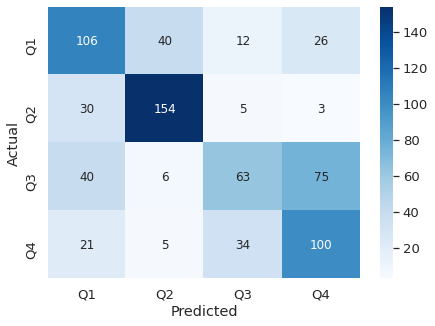

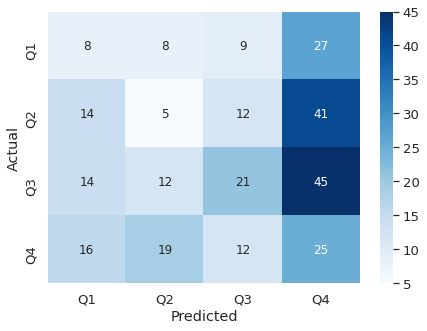

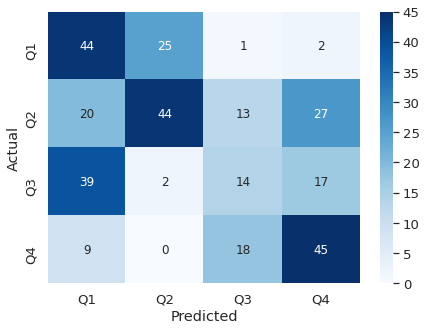

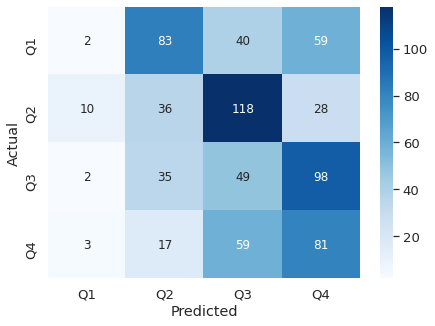

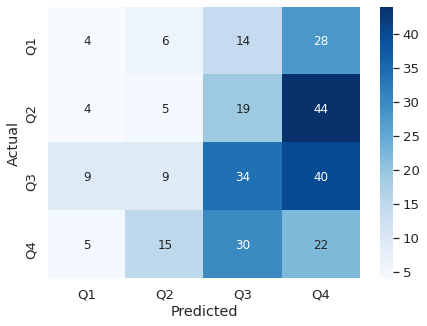

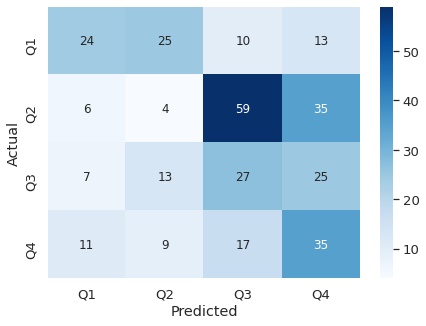

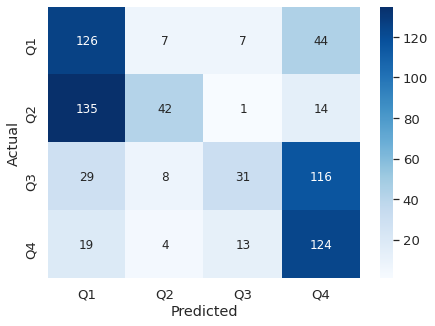

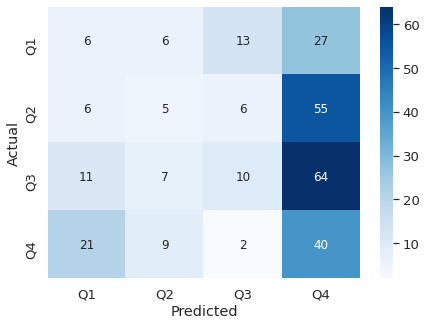

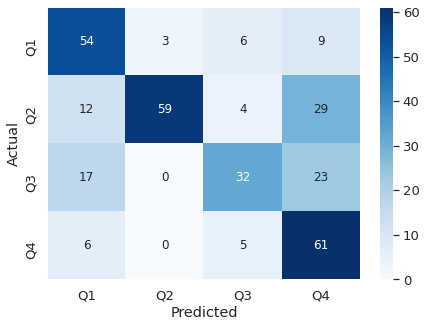

In [26]:
train_sets = [[E_train_X, E_train_y], [C_train_X, C_train_y], [T_train_X, T_train_y]]
test_sets = [[E_test_X, E_test_y], [C_test_X, C_test_y], [T_test_X, T_test_y]]
for i, train in enumerate(train_sets):
    for j, test in enumerate(test_sets):
        model = MLPClassifier(alpha=1, max_iter=1000)
        model.fit(train[0], train[1])
        var = test[0]
        var = fit_E.transform(var) if i==0 else fit_C.transform(var) if i==1 else fit_T.transform(var)  # apply features used in the training dataset
        y_pred = model.predict(var)
        y_test = test[1]  
        tr = 'English' if i==0 else 'Chinese' if i==1 else 'Turkish'
        te = 'English' if j==0 else 'Chinese' if j==1 else 'Turkish'
        print('Train: ', tr, ' & Test: ', te)   
        print(round(accuracy_score(y_test, y_pred), 2)) 
        print(classification_report(y_test, y_pred))

        # Confusion matrix
        classes = ['Q1', 'Q2', 'Q3', 'Q4']
        conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
        conf_mat.index.name = 'Actual'
        conf_mat.columns.name = 'Predicted'
        plt.figure(figsize = (7, 5))
        sns.set(font_scale = 1.2)
        sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");

## Mixed training & Test on target datasets (1 x 3 experiments)

Number of test samples:  720
              precision    recall  f1-score   support

           0       0.49      0.59      0.54       184
           1       0.78      0.66      0.71       192
           2       0.64      0.35      0.45       184
           3       0.45      0.68      0.54       160

    accuracy                           0.57       720
   macro avg       0.59      0.57      0.56       720
weighted avg       0.60      0.57      0.56       720

Confusion matrix: 



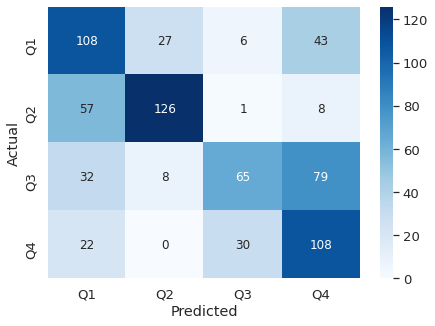

In [28]:
# Test on English
X_test = EX_test
y_test = Ey_test
selected_model = MLPClassifier(alpha=1, max_iter=1000)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion matrix: \n")
classes = ['Q1', 'Q2', 'Q3', 'Q4']
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");

Number of test samples:  288
              precision    recall  f1-score   support

           0       0.14      0.13      0.14        52
           1       0.15      0.07      0.09        72
           2       0.34      0.40      0.37        92
           3       0.18      0.24      0.20        72

    accuracy                           0.23       288
   macro avg       0.20      0.21      0.20       288
weighted avg       0.22      0.23      0.22       288

Confusion matrix: 



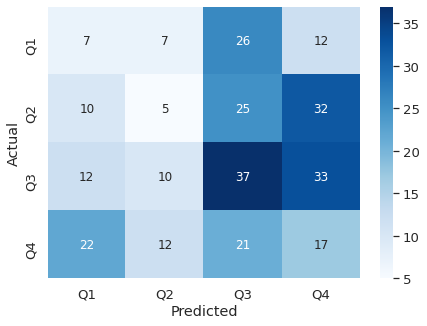

In [29]:
# Test on Chinese
X_test = CX_test
y_test = Cy_test
selected_model = MLPClassifier(alpha=1, max_iter=1000)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion matrix: \n")
classes = ['Q1', 'Q2', 'Q3', 'Q4']
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");

Number of test samples:  320
              precision    recall  f1-score   support

           0       0.59      0.81      0.68        72
           1       0.89      0.62      0.73       104
           2       0.59      0.46      0.52        72
           3       0.52      0.67      0.58        72

    accuracy                           0.64       320
   macro avg       0.65      0.64      0.63       320
weighted avg       0.67      0.64      0.64       320

Confusion matrix: 



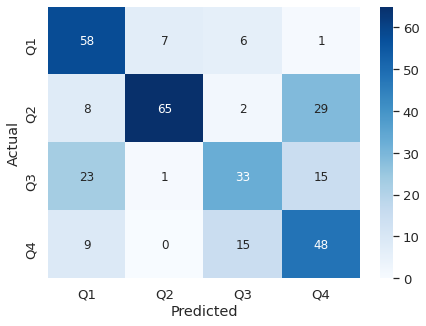

In [30]:
# Test on Turkish
X_test = TX_test
y_test = Ty_test
selected_model = MLPClassifier(alpha=1, max_iter=1000)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion matrix: \n")
classes = ['Q1', 'Q2', 'Q3', 'Q4']
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");